# A short tutorial for the `prototorch.models` plugin

## Introduction

This is a short tutorial for the [models](https://github.com/si-cim/prototorch_models) plugin of the [ProtoTorch](https://github.com/si-cim/prototorch) framework.

[ProtoTorch](https://github.com/si-cim/prototorch) provides [torch.nn](https://pytorch.org/docs/stable/nn.html) modules and utilities to implement prototype-based models. However, it is up to the user to put these modules together into models and handle the training of these models. Expert machine-learning practioners and researchers sometimes prefer this level of control. However, this leads to a lot of boilerplate code that is essentially same across many projects. Needless to say, this is a source of a lot of frustration. [PyTorch-Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) is a framework that helps avoid a lot of this frustration by handling the boilerplate code for you so you don't have to reinvent the wheel every time you need to implement a new model.

With the [prototorch.models](https://github.com/si-cim/prototorch_models) plugin, we've gone one step further and pre-packaged commonly used prototype-models like GMLVQ as [Lightning-Modules](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.lightning.html?highlight=lightning%20module#pytorch_lightning.core.lightning.LightningModule). With only a few lines to code, it is now possible to build and train prototype-models. It quite simply cannot get any simpler than this.

## Basics

First things first. When working with the models plugin, you'll probably need `torch`, `prototorch` and `pytorch_lightning`. So, we recommend that you import all three like so:

In [1]:
import prototorch as pt
import pytorch_lightning as pl
import torch

### Building Models

Let's start by building a `GLVQ` model. It is one of the simplest models to build. The only requirements are a prototype distribution and an initializer.

In [2]:
model = pt.models.GLVQ(
    hparams=dict(distribution=[1, 1, 1]),
    prototype_initializer=pt.components.Zeros(2),
)

In [3]:
print(model)

GLVQ(
  (proto_layer): LabeledComponents(components.shape: (3, 2))
  (acc_metric): Accuracy()
)


The key `distribution` in the `hparams` argument describes the prototype distribution. If it is a Python [list](https://docs.python.org/3/tutorial/datastructures.html), it is assumed that there are as many entries in this list as there are classes, and the number at each location of this list describes the number of prototypes to be used for that particular class. So, `[1, 1, 1]` implies that we have three classes with one prototype per class.   If it is a Python [tuple](https://docs.python.org/3/tutorial/datastructures.html), a shorthand of `(num_classes, prototypes_per_class)` is assumed. If it is a Python [dictionary](https://docs.python.org/3/tutorial/datastructures.html), the key-value pairs describe the class label and the number of prototypes for that class respectively. So, `{0: 2, 1: 2, 2: 2}` implies that we have three classes with labels `{1, 2, 3}`, each equipped with two prototypes. If however, the dictionary contains the keys `"num_classes"` and `"prototypes_per_class"`, they are parsed to use their values as one might expect.

The `prototype_initializer` argument describes how the prototypes are meant to be initialized. This argument has to be an instantiated object of some kind of [ComponentInitializer](https://github.com/si-cim/prototorch/blob/dev/prototorch/components/initializers.py#L27). If this is a [DimensionAwareInitializer](https://github.com/si-cim/prototorch/blob/dev/prototorch/components/initializers.py), this only requires a dimension arugment that describes the vector dimension of the prototypes. So, `pt.components.Zeros(2)` creates 2d-vector prototypes all initialized to zeros.

It is also possible to use a [ClassAwareInitializer](https://github.com/si-cim/prototorch/blob/dev/prototorch/components/initializers.py). However, this type of initializer requires data to be instantiated.

For a full list of available models, please check the [prototorch_models documentation](https://prototorch-models.readthedocs.io/en/latest/).

### Data

The preferred way to working with data in `torch` is to use the [Dataset and Dataloader API](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). There a few pre-packaged datasets available under `prototorch.datasets`. See [here](https://prototorch.readthedocs.io/en/latest/api.html#module-prototorch.datasets) for a full list of available datasets.

In [4]:
train_ds = pt.datasets.Iris(dims=[0, 2])

In [5]:
type(train_ds)

prototorch.datasets.iris.Iris

In [6]:
train_ds.data.shape, train_ds.targets.shape

((150, 2), (150,))

Once we have such a dataset, we could wrap it in a `Dataloader` to load the data in batches, and possibly apply some transformations on the fly.

In [7]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2)

In [8]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [9]:
x_batch, y_batch = next(iter(train_loader))
print(f"{x_batch=}, {y_batch=}")

x_batch=tensor([[5.1000, 1.4000],
        [4.9000, 1.4000]]), y_batch=tensor([0., 0.])


This perhaps seems like a lot of work for a small dataset that fits completely in memory. However, this comes in very handy when dealing with huge datasets that can only be processed in batches.

### Training

If you're familiar with other deep learning frameworks, you might perhaps expect a `.fit(...)` or `.train(...)` method. However, in PyTorch-Lightning, this is done slightly differently. We first create a trainer and then pass the model and the Dataloader to `trainer.fit(...)` instead. So, it is more functional in style than object-oriented.

In [10]:
trainer = pl.Trainer(max_epochs=2, weights_summary=None)

GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


In [11]:
trainer.fit(model, train_loader)

/home/blackfly/pyenvs/pt/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/blackfly/pyenvs/pt/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

### From data to a trained model - a very minimal example

In [12]:
train_ds = pt.datasets.Iris(dims=[0, 2])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)

model = pt.models.GLVQ(
    dict(distribution=(3, 2), lr=0.1),
    prototype_initializer=pt.components.SMI(train_ds),
)

trainer = pl.Trainer(max_epochs=50, weights_summary=None)
trainer.fit(model, train_loader)

GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

## Advanced

### Initializing prototypes with a subset of a dataset (along with transformations)

In [13]:
import prototorch as pt
import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.datasets import MNIST

In [14]:
from matplotlib import pyplot as plt

In [15]:
train_ds = MNIST(
    "~/datasets",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ToTensor(),
    ]),
)

In [16]:
s = int(0.05 * len(train_ds))
init_ds, rest_ds = torch.utils.data.random_split(train_ds, [s, len(train_ds) - s])

In [17]:
init_ds

In [18]:
model = pt.models.ImageGLVQ(
    dict(distribution=(10, 5)),
    prototype_initializer=pt.components.SMI(init_ds),
)

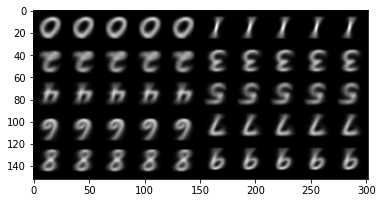

In [19]:
plt.imshow(model.get_prototype_grid(num_columns=10))

## FAQs

### How do I Retrieve the prototypes and their respective labels from the model?

For prototype models, the prototypes can be retrieved (as `torch.tensor`) as `model.prototypes`. You can convert it to a NumPy Array by calling `.numpy()` on the tensor if required.

```python
>>> model.prototypes.numpy()
```

Similarly, the labels of the prototypes can be retrieved via `model.prototype_labels`.

```python
>>> model.prototype_labels
```

### How do I make inferences/predictions/recall with my trained model?

The models under [prototorch.models](https://github.com/si-cim/prototorch_models) provide a `.predict(x)` method for making predictions. This returns the predicted class labels. It is essential that the input to this method is a `torch.tensor` and not a NumPy array. Model instances are also callable. So, you could also just say `model(x)` as if `model` were just a function. However, this returns a (pseudo)-probability distribution over the classes.

#### Example

```python
>>> y_pred = model.predict(torch.Tensor(x_train))  # returns class labels
```
or, simply
```python
>>> y_pred = model(torch.Tensor(x_train))  # returns probabilities
```